# =============================================================================
# McDonald's Segmentation Extraction Pipeline
# =============================================================================
# This pipeline implements segmentation extraction :
#  - Data Import and Cleaning (including conversion of verbal responses to binary)
#  - Dimensionality Reduction (PCA) and Perceptual Mapping
#  - K-Means Clustering across different numbers of segments (with a scree plot)
#  - Bootstrap Stability Analysis (using Adjusted Rand Index)
#  - Model Evaluation using Information Criteria (AIC, BIC, ICL)
#  - Comparison with Gaussian Mixture Models (GMM)
#  - Latent Class Regression to model "Like" as a function of perceptions
#  - Comprehensive cluster profiling and visualization
#
# Each section is fully documented with inline comments.
# =============================================================================



In [2]:
!pip install bioinfokit

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for bioinfokit: filename=bioinfokit-2.1.4-py3-none-any.whl size=59317 sha256=eeb785139f8c8503614ea41e96299b6c599b2995e400cddf5b993e5bb274117e
  Stored in directory: c:\users\adity\appdata\local\pip\cache\wheels\b4\76\43\7fa2c349dac62f041fe8d85c9f48e47ca25fc39fd79d0b5f5e
  Created wheel for matplotlib-venn: filename=matplotlib_venn-1.1.2-py3-none-any.whl size=45405 sha256=713d2bea4e2151ea4319cbd1d304fb4cc9d8a348e64a932e255c001bcd6a90e0
  Stored in directory: c:\users\adity\appdata\local\pip\cache\wheels\c2\47\0c\f014c55a1cfd56dce41a1cafd23e3c59065

In [3]:
# -----------------------
# 1. Import Required Libraries
# -----------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.utils import resample
from sklearn.mixture import GaussianMixture
from scipy.stats import entropy
from patsy import dmatrices, dmatrix
from statsmodels.graphics.mosaicplot import mosaic
from bioinfokit.visuz import cluster

In [4]:

# -----------------------
# 2. Data Import and Initial Exploration
# -----------------------
data = pd.read_csv("mcdonalds.csv")
data1 = pd.read_csv("mcdonalds.csv")
print("Columns:", data.columns)
print("Shape:", data.shape)
print("First 3 rows:\n", data.head(3))

Columns: Index(['yummy', 'convenient', 'spicy', 'fattening', 'greasy', 'fast', 'cheap',
       'tasty', 'expensive', 'healthy', 'disgusting', 'Like', 'Age',
       'VisitFrequency', 'Gender'],
      dtype='object')
Shape: (1453, 15)
First 3 rows:
   yummy convenient spicy fattening greasy fast cheap tasty expensive healthy  \
0    No        Yes    No       Yes     No  Yes   Yes    No       Yes      No   
1   Yes        Yes    No       Yes    Yes  Yes   Yes   Yes       Yes      No   
2    No        Yes   Yes       Yes    Yes  Yes    No   Yes       Yes     Yes   

  disgusting Like  Age      VisitFrequency  Gender  
0         No   -3   61  Every three months  Female  
1         No   +2   51  Every three months  Female  
2         No   +1   62  Every three months  Female  


In [5]:
# -----------------------
# 3. Data Conversion: Transform Verbal Responses into Binary
# -----------------------
MD = data.iloc[:, 0:11].replace("Yes", 1).replace("No", 0)
mean_vals = round(MD.mean(), 2)
print("Means of segmentation variables:\n", mean_vals)

Means of segmentation variables:
 yummy         0.55
convenient    0.91
spicy         0.09
fattening     0.87
greasy        0.53
fast          0.90
cheap         0.60
tasty         0.64
expensive     0.36
healthy       0.20
disgusting    0.24
dtype: float64


C:\Users\adity\AppData\Local\Temp\ipykernel_14100\1247939183.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  MD = data.iloc[:, 0:11].replace("Yes", 1).replace("No", 0)


In [6]:
# -----------------------
# 4. Dimensionality Reduction: PCA & Perceptual Mapping
# -----------------------
MD_pca = PCA()
MD_P = MD_pca.fit_transform(MD)
MD_pca.fit(MD)
PV = MD_pca.explained_variance_ratio_   
SD = np.sqrt(MD_pca.explained_variance_)

pc_labels = ["PC{}".format(i+1) for i in range(len(SD))]

In [7]:
pca_summary = pd.DataFrame({
    "Standard Deviation": SD,
    "Proportion of Variance": PV,
    "Cumulative Proportion": PV.cumsum()
}, index=pc_labels)
print("PCA Summary:\n", pca_summary)

PCA Summary:
       Standard Deviation  Proportion of Variance  Cumulative Proportion
PC1             0.757050                0.299447               0.299447
PC2             0.607456                0.192797               0.492244
PC3             0.504619                0.133045               0.625290
PC4             0.398799                0.083096               0.708386
PC5             0.337405                0.059481               0.767866
PC6             0.310275                0.050300               0.818166
PC7             0.289697                0.043849               0.862015
PC8             0.275122                0.039548               0.901563
PC9             0.265251                0.036761               0.938323
PC10            0.248842                0.032353               0.970677
PC11            0.236903                0.029323               1.000000


Rotation Matrix (Factor Loadings):
               PC1    PC2    PC3    PC4    PC5    PC6    PC7    PC8    PC9  \
yummy      -0.477  0.364 -0.304 -0.055 -0.308  0.171  0.281  0.013  0.572   
convenient -0.155  0.016 -0.063  0.142  0.278 -0.348  0.060 -0.113 -0.018   
spicy      -0.006  0.019 -0.037 -0.198  0.071 -0.355 -0.708  0.376  0.400   
fattening   0.116 -0.034 -0.322  0.354 -0.073 -0.407  0.386  0.590 -0.161   
greasy      0.304 -0.064 -0.802 -0.254  0.361  0.209 -0.036 -0.138 -0.003   
fast       -0.108 -0.087 -0.065  0.097  0.108 -0.595  0.087 -0.628  0.166   
cheap      -0.337 -0.611 -0.149 -0.119 -0.129 -0.103  0.040  0.140  0.076   
tasty      -0.472  0.307 -0.287  0.003 -0.211 -0.077 -0.360 -0.073 -0.639   
expensive   0.329  0.601  0.024 -0.068 -0.003 -0.261  0.068  0.030  0.067   
healthy    -0.214  0.077  0.192 -0.763  0.288 -0.178  0.350  0.176 -0.186   
disgusting  0.375 -0.140 -0.089 -0.370 -0.729 -0.211  0.027 -0.167 -0.072   

             PC10   PC11  
yummy      -

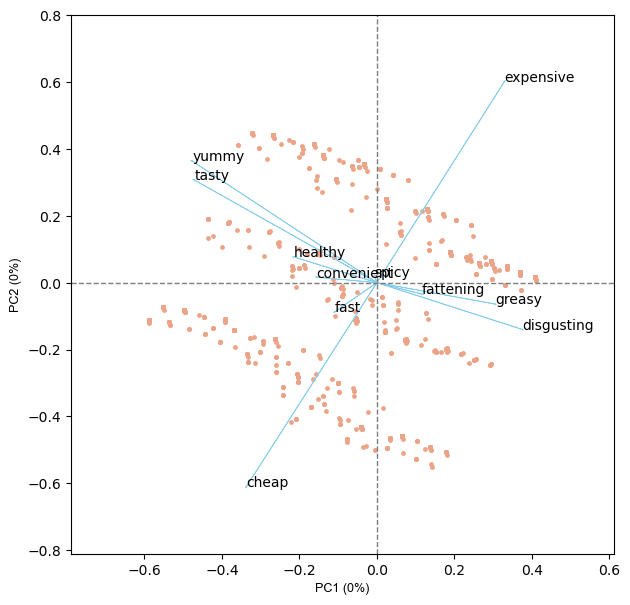

In [8]:
loadings = MD_pca.components_
rot_matrix = loadings.T
rot_df = pd.DataFrame(rot_matrix, index=MD.columns, columns=pc_labels)
rot_df = round(-rot_df, 3)
print("Rotation Matrix (Factor Loadings):\n", rot_df)

cluster.biplot(cscore=MD_P, loadings=-loadings, labels=data.columns.values, var1=0,
               var2=0, show=True, dim=(7,7))

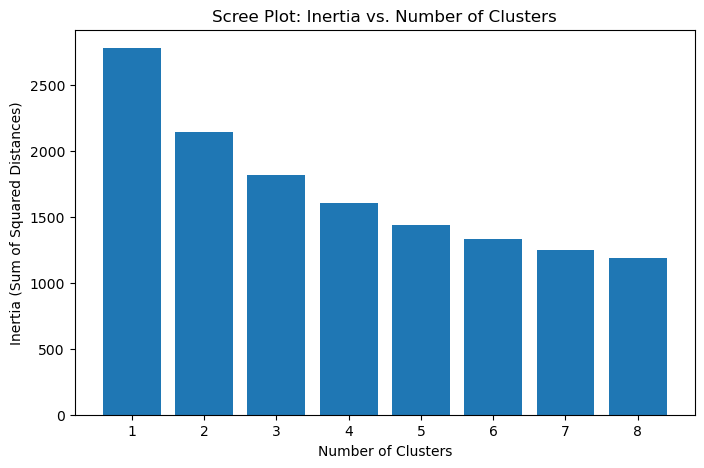

In [9]:
# -----------------------
# 5. K-Means Clustering and Scree Plot Analysis
# -----------------------
np.random.seed(1234)
nrep = 10
k_values = range(1, 9)
inertia_list = []
MD_km_models = {}

for k in k_values:
    kmeans = KMeans(n_clusters=k, n_init=nrep, random_state=1234)
    kmeans.fit(MD)
    inertia_list.append(kmeans.inertia_)
    MD_km_models[str(k)] = kmeans

plt.figure(figsize=(8, 5))
plt.bar(k_values, inertia_list)
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia (Sum of Squared Distances)")
plt.title("Scree Plot: Inertia vs. Number of Clusters")
plt.show()


C:\Users\adity\AppData\Local\Temp\ipykernel_14100\305050610.py:23: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(stability_indices, labels=range(2, 9), whis=10)


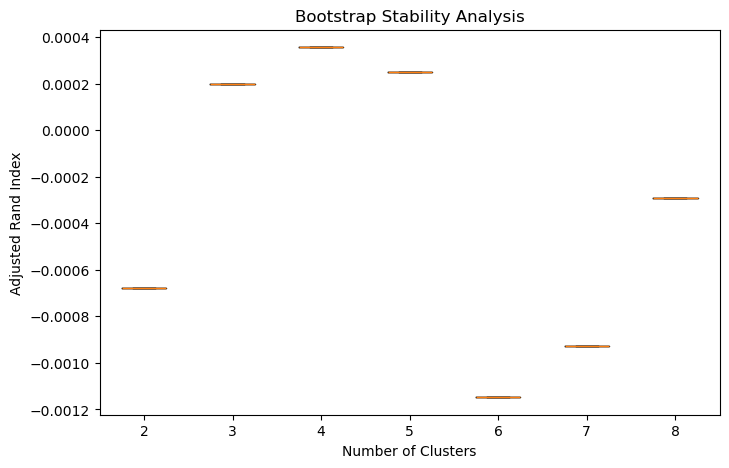

In [10]:
# -----------------------
# 6. Bootstrap Stability Analysis (Adjusted Rand Index)
# -----------------------
np.random.seed(1234)
n_boot = 100
bootstrap_samples = [resample(MD.values, random_state=1234) for _ in range(n_boot)]

stability_indices = []
for k in range(2, 9):
    ari_scores = []
    for sample in bootstrap_samples:
        km = KMeans(n_clusters=k, n_init=nrep, random_state=1234)
        km.fit(sample)
        labels_boot = km.predict(sample)
        labels_orig = km.predict(MD.values)
        ari = adjusted_rand_score(labels_orig, labels_boot)
        ari_scores.append(ari)
    stability_indices.append(ari_scores)

stability_indices = np.array(stability_indices).T

plt.figure(figsize=(8, 5))
plt.boxplot(stability_indices, labels=range(2, 9), whis=10)
plt.xlabel("Number of Clusters")
plt.ylabel("Adjusted Rand Index")
plt.title("Bootstrap Stability Analysis")
plt.show()

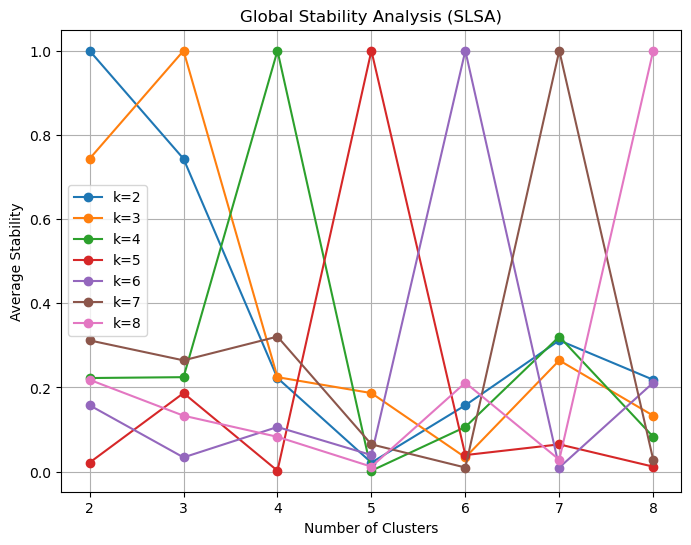

In [11]:
# -----------------------
# 7. Global Stability Analysis (SLSA)
# -----------------------
global_stability = []
for k in range(2, 9):
    labels_k = MD_km_models[str(k)].predict(MD)
    global_stability.append(labels_k)

plt.figure(figsize=(8, 6))
for i, k in enumerate(range(2, 9)):
    plt.plot(range(2, 9), [np.mean(global_stability[i] == lab) for lab in global_stability],
             marker='o', label=f'k={k}')
plt.xlabel("Number of Clusters")
plt.ylabel("Average Stability")
plt.title("Global Stability Analysis (SLSA)")
plt.xticks(range(2, 9))
plt.legend()
plt.grid(True)
plt.show()




Model Evaluation Criteria:
    k       LogLik          AIC          BIC          ICL
0  2 -2146.062044  4296.124088  4306.686859  4306.015908
1  3 -1896.330266  3798.660532  3814.504689  3813.529671
2  4 -1604.234391  3216.468783  3237.594326  3236.258023
3  5 -1502.697153  3015.394306  3041.801234  3040.267284
4  6 -1348.665399  2709.330799  2741.019113  2739.277954
5  7 -1249.233890  2512.467780  2549.437480  2547.530062
6  8 -1203.646165  2423.292330  2465.543415  2463.533662


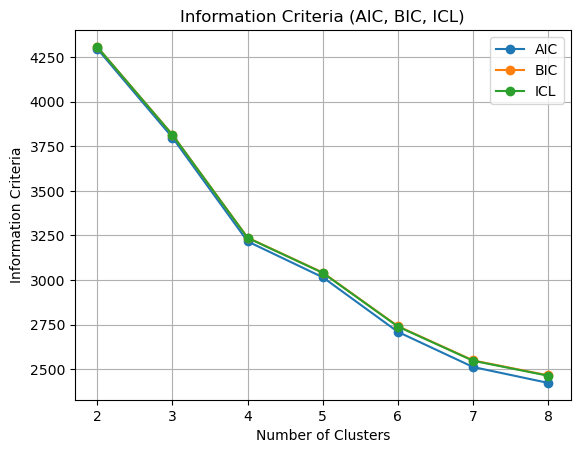

In [12]:
# -----------------------
# 8. Model Evaluation using Information Criteria (AIC, BIC, ICL)
# -----------------------
np.random.seed(1234)
k_values = range(2, 9)
MD_m28 = []
for k in k_values:
    model = KMeans(n_clusters=k, random_state=1234)
    model.fit(MD.values)
    log_likelihood = -model.inertia_
    n_samples, _ = MD.shape
    aic = -2 * log_likelihood + 2 * k
    bic = -2 * log_likelihood + np.log(n_samples) * k
    counts = np.bincount(model.labels_)
    probs = counts / counts.sum()
    icl = bic - entropy(probs)
    MD_m28.append((k, log_likelihood, aic, bic, icl))
MD_m28 = pd.DataFrame(MD_m28, columns=['k', 'LogLik', 'AIC', 'BIC', 'ICL'])
print("Model Evaluation Criteria:\n", MD_m28)
plt.plot(MD_m28['k'], MD_m28['AIC'], marker='o', label='AIC')
plt.plot(MD_m28['k'], MD_m28['BIC'], marker='o', label='BIC')
plt.plot(MD_m28['k'], MD_m28['ICL'], marker='o', label='ICL')
plt.xlabel("Number of Clusters")
plt.ylabel("Information Criteria")
plt.title("Information Criteria (AIC, BIC, ICL)")
plt.legend()
plt.grid(True)
plt.show()


In [13]:
# -----------------------
# 9. Comparison with Gaussian Mixture Models (GMM)
# -----------------------
k = 4
km4 = KMeans(n_clusters=k, random_state=1234)
km4.fit(MD)
km4_labels = km4.predict(MD)
gmm4 = GaussianMixture(n_components=k, random_state=1234)
gmm4.fit(MD)
gmm4_labels = gmm4.predict(MD)
results = pd.DataFrame({'KMeans': km4_labels, 'GMM': gmm4_labels})
print("Cross-tabulation of KMeans vs. GMM clusters:\n", pd.crosstab(results['KMeans'], results['GMM']))

Cross-tabulation of KMeans vs. GMM clusters:
 GMM       0    1    2    3
KMeans                    
0       508    0    4   39
1         0  215   11    4
2        44    3  267    8
3         0   36   15  299


In [14]:
# -----------------------
# 10. Latent Class Regression to Model "Like" as a Function of Perceptions
# -----------------------
like_mapping = {'I HATE IT!-5': -5, '-4': -4, '-3': -3, '-2': -2, '-1': -1,
                '0': 0, '1': 1, '2': 2, '3': 3, '4': 4, 'I LOVE IT!+5': 5}
data['Like.n'] = data['Like'].map(like_mapping)
print("Distribution of Like.n:\n", data['Like.n'].value_counts())
independent_vars = data.columns[0:11]
formula_str = 'Like ~ ' + ' + '.join(independent_vars)
_, design_matrix = dmatrices(formula_str, data=data)
print("Design matrix (first 5 rows):\n", design_matrix[:5])
X_reg = dmatrix(design_matrix.design_info, data=data)
y_reg = dmatrix('Like', data=data)
gmm_reg = GaussianMixture(n_components=2, n_init=10, random_state=1234)
gmm_reg.fit(X_reg, y_reg)
print("Latent Class Regression Model:\n", gmm_reg)

Distribution of Like.n:
 Like.n
 0.0    169
-3.0     73
-4.0     71
-2.0     59
-1.0     58
Name: count, dtype: int64
Design matrix (first 5 rows):
 [[1. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 0.]
 [1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 0.]
 [1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0.]
 [1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 0. 1.]
 [1. 0. 1. 0. 1. 1. 1. 1. 0. 0. 1. 0.]]
Latent Class Regression Model:
 GaussianMixture(n_components=2, n_init=10, random_state=1234)


Segment Profiles:
       yummy  convenient     spicy  fattening    greasy      fast     cheap  \
0  0.019231    0.906593  0.082418   0.931319  0.596154  0.956044  0.901099   
1  0.020833    0.679167  0.075000   0.916667  0.708333  0.741667  0.066667   
2  0.966229    0.981238  0.084428   0.778612  0.348968  0.958724  0.923077   
3  0.873418    0.958861  0.136076   0.905063  0.607595  0.857595  0.107595   

      tasty  expensive   healthy  disgusting  
0  0.285714   0.013736  0.074176    0.329670  
1  0.079167   0.895833  0.062500    0.725000  
2  0.973734   0.018762  0.339587    0.046904  
3  0.930380   0.917722  0.208861    0.107595  


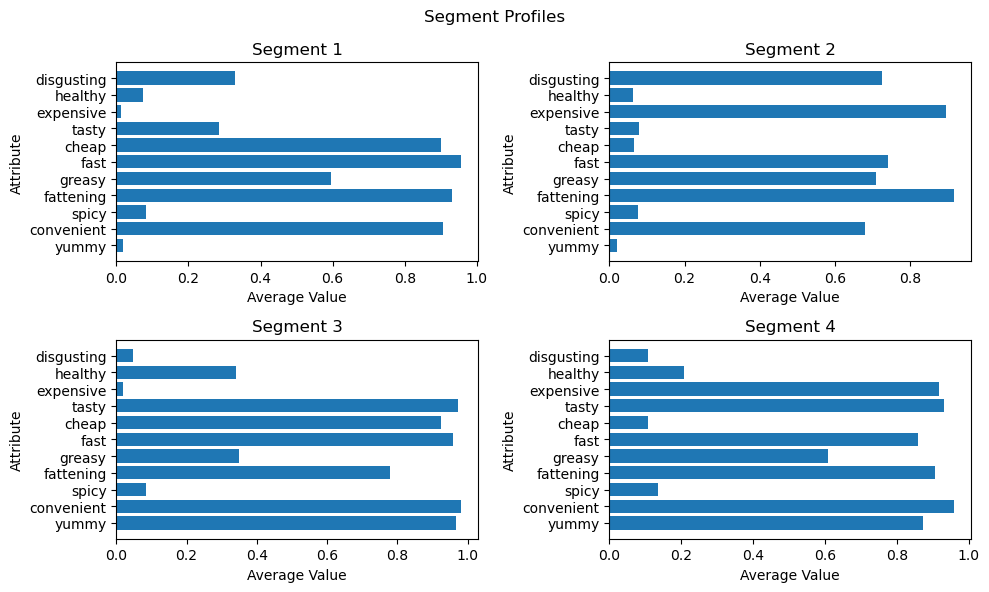

In [15]:
# -----------------------
# 11. Comprehensive Cluster Profiling and Visualization
# -----------------------
km4 = MD_km_models['4']
labels_4 = km4.labels_
segment_profile = MD.groupby(labels_4).mean()
print("Segment Profiles:\n", segment_profile)
fig, axs = plt.subplots(2, 2, figsize=(10, 6))
for i in range(4):
    ax = axs[i//2, i%2]
    ax.barh(range(segment_profile.shape[1]), segment_profile.iloc[i])
    ax.set_title(f"Segment {i+1}")
    ax.set_yticks(range(segment_profile.shape[1]))
    ax.set_yticklabels(MD.columns)
    ax.set_xlabel("Average Value")
    ax.set_ylabel("Attribute")
fig.suptitle("Segment Profiles")
fig.tight_layout()
plt.show()

# =============================================================================
# End of Segmentation Extraction Pipeline
# =============================================================================